In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from plot_drift import plot_drift
from plot_trajectory import plot_trajectory

In [4]:
#!./run.sh
output_dir = "output/dust_diffusion/"

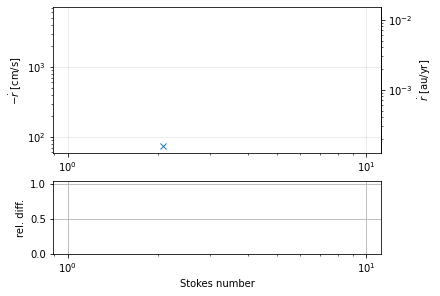

In [5]:
plot_drift(output_dir);

In [71]:

import astropy.units as u
import numpy as np

def norm(a,b):
    return np.sqrt(a**2 + b**2)

def calc_orbital_elements(particle, Mstar=1):
    """ Calculate orbital elements using postition (x), velocities (v) and stellar mass (M
    star) """
    G = 1 # in the units used
    mu = Mstar*G #*const.G

    # cartesian
    # x1 = particle['x1']
    # x2 = particle['x2']
    # v1 = particle['v1']
    # v2 = particle['v2']
    # r = norm(x1, x2)
    # v = norm(v1, v2)
    # h = x1*v2 - v1*x2

    # polar
    r = particle["r"]
    phi = particle["phi"]
    r_dot = particle["r_dot"]
    phi_dot = particle["phi_dot"]
    h = r*r*phi_dot
    v = norm(r_dot, r*phi_dot)


    E = v**2/2 - mu/r
    a = -mu/(2*E)
    e = np.sqrt(np.minimum(1 - h**2/(a*mu), 1e20))
    nu = np.arccos( (a*(1-e**2) - r)/(e*r) )
    omega = nu

    particle['E'] = E
    particle['a'] = a
    particle['e'] = e
    particle['Periastron'] = omega
    particle['TrueAnomaly'] = nu


dr/dt -3.711194638138782e-05


Text(0, 0.5, '1e5*dr/dt')

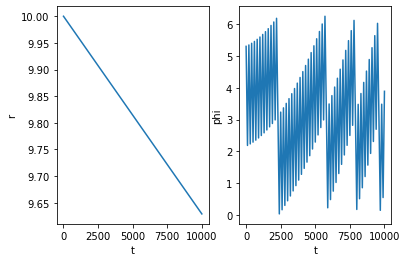

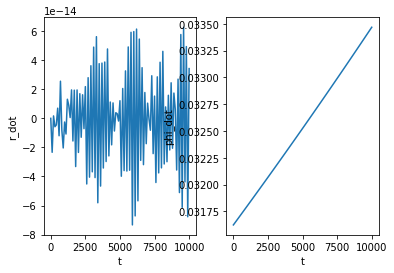

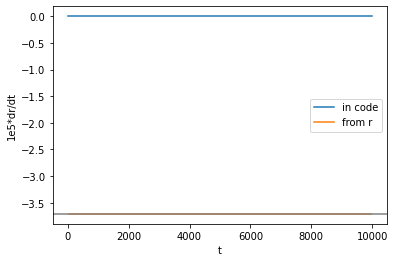

In [77]:
from load_dust import construct_dust_trajectories, get_output_times
particles = construct_dust_trajectories(output_dir, units=False)
r = np.array(particles[0]["r"])
t = np.array(get_output_times(output_dir, units=False))


print("dr/dt", (r[-1]-r[0])/(t[-1] - t[0]))
# plot_trajectory(output_dir, plotargs={"ls":"none", "marker":"x"});


def plot_two(a,b):
    fig, axes = plt.subplots(ncols=2)    

    ax = axes[0]
    ax.plot(t, particles[0][a])
    ax.set_xlabel("t")
    ax.set_ylabel(a)

    ax = axes[1]
    ax.plot(t, particles[0][b])
    ax.set_xlabel("t")
    ax.set_ylabel(b)

plot_two("r", "phi")
plot_two("r_dot", "phi_dot")

fig, ax = plt.subplots()
ax.plot(t, 1e5*particles[0]["r_dot"], label="in code")
ax.plot(0.5*(t[1:] + t[:-1]), 1e5*(r[1:] - r[:-1])/(t[1:] - t[:-1]), label="from r")
ax.legend()

ax.axhline(-3.7111153967326794e-05*1e5, color="grey")

ax.set_xlabel("t")
ax.set_ylabel("1e5*dr/dt")


<ipython-input-71-1b7dcbd98aa6>:33: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt(np.minimum(1 - h**2/(a*mu), 1e20))
<ipython-input-71-1b7dcbd98aa6>:34: RuntimeWarning: divide by zero encountered in divide
  nu = np.arccos( (a*(1-e**2) - r)/(e*r) )
<ipython-input-71-1b7dcbd98aa6>:34: RuntimeWarning: invalid value encountered in arccos
  nu = np.arccos( (a*(1-e**2) - r)/(e*r) )


Text(0, 0.5, '1e4*e')

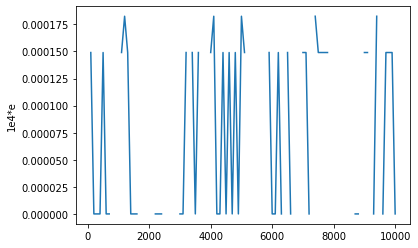

In [78]:
calc_orbital_elements(particles[0])

fig, ax = plt.subplots()
ax.plot(t, 1e4*particles[0]["e"])
ax.set_ylabel("1e4*e")

The amplitude of oscillation in rdot is around 2.3e-4 without correction of phi_dot and reduced to 1.5e-4 when correcting phi_dot with $\sqrt(r_{old}/r_{new})$.

This turns out to be the incorrect factor. It's the right factor for correcting the azimuthal velocity, but fargo uses the time derivative of the azimuthal angle.
Adding another power of $r_{old}/r_{new}$ solves the issue.

The azimuthal velocity before and after the kick are
\begin{align}
v_\phi^{old} = \sqrt{\frac{GM}{r^{old}}}
\end{align}
and
\begin{align}
v_\phi^{new} = \sqrt{\frac{GM}{r^{new}}} = \sqrt{\frac{GM}{r^{old}}\frac{r^{old}}{r^{new}}} = v_\phi^{old} \sqrt{\frac{r^{old}}{r^{new}}}
\end{align}
yielding the ratio of the radii with a power of 1/2.

For the time derivative of the angle, connected to $v_\phi$ by $v_\phi = r \dot{\phi}$, it's

\begin{align}
\dot{\phi}^{new} = \frac{v_\phi^{new}}{r^{new}} = v_\phi^{old} \sqrt{\frac{r^{old}}{r^{new}}} \frac{1}{r^{old}} \frac{r^{old}}{r^{new}} = \frac{v_\phi^{old}}{r^{old}} \left( \frac{r^{old}}{r^{new}} \right)^{1.5} = \dot{\phi}^{old} \left( \frac{r^{old}}{r^{new}} \right)^{1.5}
\end{align}

In [61]:

mu = 1
particle = particles[0]
r = particle["r"]
phi = particle["phi"]
r_dot = particle["r_dot"]
phi_dot = particle["phi_dot"]
h = r*r*phi_dot
v = norm(r_dot, r*phi_dot)


E = v**2/2 - mu/r
a = -mu/(2*E)

print(h**2, a)

e = np.sqrt(np.abs(1 - h**2/(a*mu)))
nu = np.arccos( (a*(1-e**2) - r)/(e*r) )
omega = nu

print(e)

[10.          9.99985155  9.99970311  9.99955466  9.99940622  9.99925778
  9.99910934  9.99896091  9.99881247  9.99866404  9.9985156   9.99836717
  9.99821874  9.99807032  9.99792189  9.99777347  9.99762504  9.99747662
  9.9973282   9.99717978  9.99703136  9.99688295  9.99673453  9.99658612
  9.99643771  9.9962893 ] [10.          9.99985155  9.99970311  9.99955468  9.99940624  9.99925781
  9.99910939  9.99896097  9.99881255  9.99866414  9.99851573  9.99836732
  9.99821892  9.99807052  9.99792213  9.99777374  9.99762535  9.99747697
  9.99732859  9.99718022  9.99703184  9.99688347  9.99673511  9.99658675
  9.99643839  9.99629003]
[1.49011612e-08 1.11330823e-05 2.22632998e-05 3.33878631e-05
 4.45040087e-05 5.56089435e-05 6.66998912e-05 7.77740867e-05
 8.88287647e-05 9.98611587e-05 1.10868510e-04 1.21848075e-04
 1.32797103e-04 1.43712864e-04 1.54592630e-04 1.65433684e-04
 1.76233317e-04 1.86988828e-04 1.97697538e-04 2.08356767e-04
 2.18963856e-04 2.29516153e-04 2.40011023e-04 2.50445846e-0

In [67]:
import disgrid
d = disgrid.Data(output_dir)
p = d.get(var="x", planet=0)

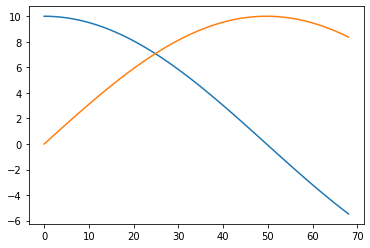

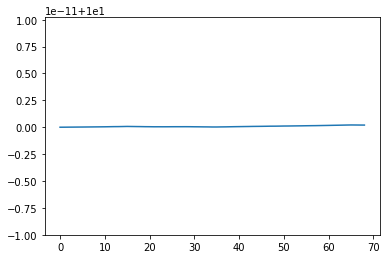

In [69]:
x = d.get(var="x", planet=1)
y = d.get(var="y", planet=1)

fig, ax = plt.subplots()
ax.plot(x.time, x.data)
ax.plot(y.time, y.data)

fig, ax = plt.subplots()
ax.plot(x.time, np.sqrt(x.data**2 + y.data**2))

In [6]:
def calc_stokes(size, particle_density, surface_density):
    return np.pi*size*particle_density / (2*surface_density)

In [7]:
import astropy.units as u
calc_stokes(1e-4*u.cm, 2.65*u.g/u.cm**3, 10*u.g/u.cm**2)

<Quantity 4.16261027e-05>

In [8]:
calc_stokes(100*u.cm, 2.65*u.g/u.cm**3, 10*u.g/u.cm**2)

<Quantity 41.62610266>

Stokes number calculation is correct in the FARGO code in case of Epstein drag only

In [9]:
4.16/1.51

2.7549668874172184

In [10]:
1/np.sqrt(1.4)

0.8451542547285166

In [11]:
1/1.4

0.7142857142857143

In [12]:
import astropy.units as u
import astropy.constants as const

Gas density in cgs

In [13]:
rhog = (10*u.g/u.cm**2 / (np.sqrt(2*np.pi) * 0.05* 1 * u.au)).to("g/cm3")
rhog

<Quantity 5.33352886e-12 g / cm3>

mean free path according to HB03 https://iopscience.iop.org/article/10.1086/345472/pdf eq 20
l (cm) = 4.72e-9 / (rho_g / (g/cm3)) cm

In [14]:
l = 4.72e-9 *u.cm / rhog.to_value("g/cm3")
l

<Quantity 884.96755595 cm>

For a s = 1e-4 cm particle

In [15]:
f = (1e-4*u.cm) / (1e-4*u.cm + l)
f

<Quantity 1.1299848e-07>

In [16]:
m0 = 2.35*u.u
temperature = 626.9*u.K
vthermal = np.sqrt(8 * const.k_B * temperature / (np.pi*m0))

In [17]:
vthermal.decompose()

<Quantity 2376.57953771 m / s>

In [18]:
np.sqrt(8/np.pi)*0.05

0.07978845608028655

in the code at r=1, vthermal = 0.07979 calcualting from temperature

In [19]:
np.sqrt(8/np.pi)*0.05

0.07978845608028655

In Picogna et al 2015, Fig. C2 shows the theoretical drift rate for a particle of stokes number  7.4e-4, which is roughly 5e-6 in the units shown.
The axis is labeled as cm/s, however, the order of magnitude fits for au/yr

In [20]:
sigmaslope = -1
temperatureslope = -1
Mstar = 0.05*u.solMass
h = 0.05
r = 1*u.au
stokes = 7.4e-4
vK = np.sqrt(const.G*Mstar/r).decompose()
eta = h**2 * (sigmaslope + temperatureslope)
vdrift = eta*vK/(stokes + stokes**-1)
vdrift.to("au/yr")

<Quantity -5.19826188e-06 AU / yr>

In [21]:
vK

<Quantity 6660.059562 m / s>

In [22]:
np.sqrt(8/np.pi)*0.05*vK

<Quantity 531.39586986 m / s>

In [23]:
885/1e-4/2

4425000.0

In [24]:
10*(1*u.au).to_value("cm")

149597870700000.0

In [25]:
import numpy as np
import astropy.units as u
import astropy.constants as const
from drift_theo import vdrift_theo
vdrift_theo(7.4e-4, 1*u.au, Mstar=0.55*u.solMass, h=0.05).to("au/yr")

<Quantity -1.72406842e-05 AU / yr>

In [26]:
from load_dust import construct_dust_trajectories
import matplotlib.pyplot as plt
import numpy as np

p = construct_dust_trajectories("output/dust_drift/")[0]

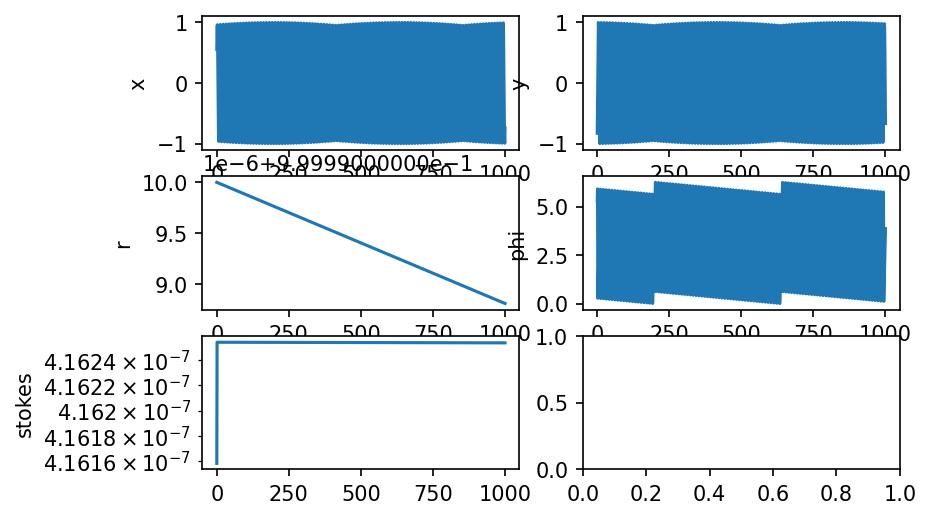

In [27]:
fig, axes = plt.subplots(ncols=2, nrows=3, dpi=150)

for ax, name in zip(axes.ravel(), ["x", "y", "r", "phi", "stokes"]):
    ax.plot(p[name])
    ax.set_ylabel(name)
    
axes[2,0].set_yscale("log")